In [50]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [25]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [81]:
def visualize_umaps(model_path, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/cingulate_ACCpatterns_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)
    
    if verbose:
        print("Data df:")
        print(data_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    # plot for predicted labels
    print("SVM labels")
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_model_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]

            plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

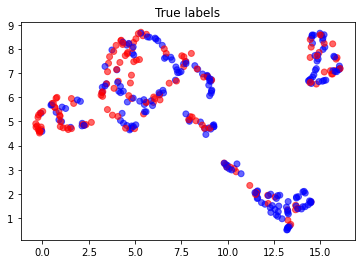

SVM labels


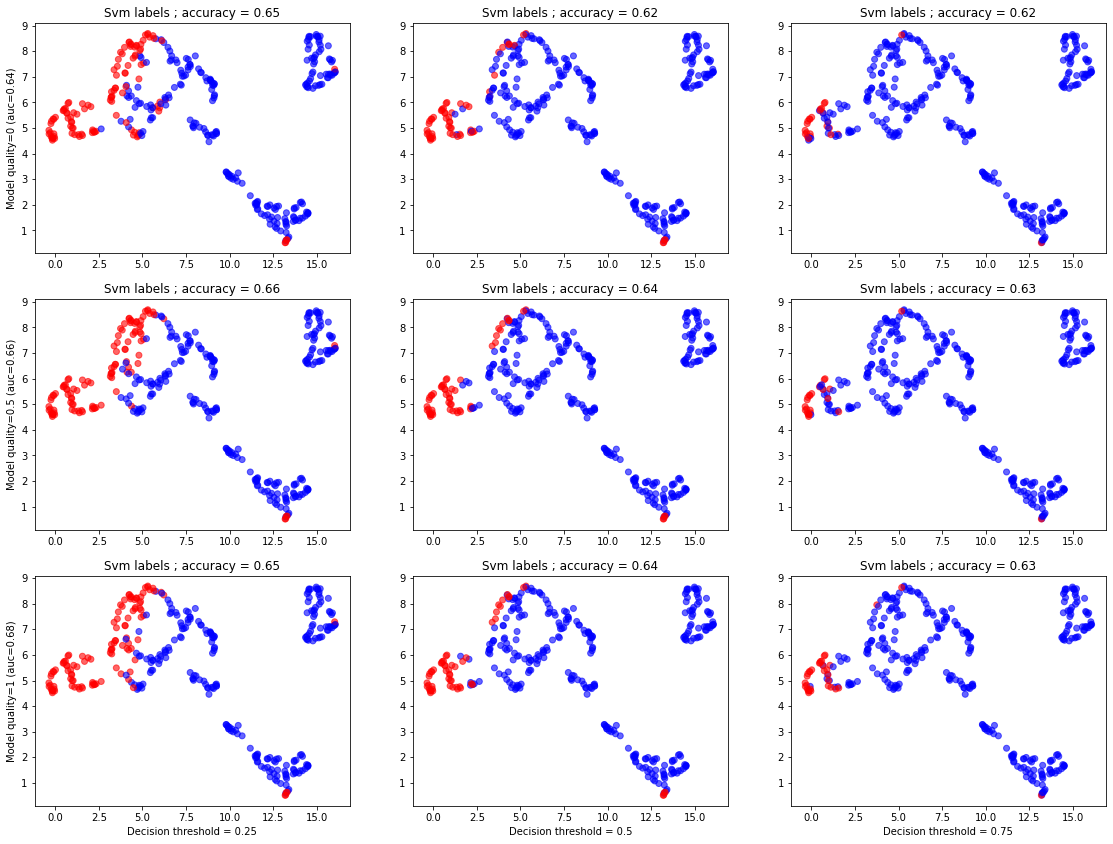

In [82]:
# test model
model_path = "/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/09-47-47"
visualize_umaps(model_path, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], verbose=False)

In [83]:
def full_visualization(model_path):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/cingulate_ACCpatterns_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    visualize_umaps(model_path)

## Choose relevent SimCLR models

In [84]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
bdd.sort_values(by='auc', ascending=False, inplace=True)
bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
102,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.694205,0.008692,0.669267,0.009264,pointnet,16,0.15,100,True,...,6,250,30,30,0.5,0.5,4.367986,4.052493,cingulate_HCP_half_1,pointnet
75,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.693590,0.051831,0.619449,0.052646,densenet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,0.762840,1.369004,cingulate_HCP_half_1,Run_03_aymeric
25,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.692153,0.049598,0.629595,0.054254,densenet,16,0.15,100,True,...,6,250,30,30,0.1,0.1,1.032371,2.509686,cingulate_HCP_half_1,Run_03_aymeric
110,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.678702,0.006920,0.668692,0.007873,pointnet,16,0.05,100,True,...,6,250,30,30,0.1,0.1,1.336895,2.419318,cingulate_HCP_half_1,pointnet
12,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.678640,0.044072,0.634545,0.037935,convnet,16,0.15,100,False,...,10,250,30,30,0.1,0.1,0.263586,0.195343,cingulate_HCP_half_1,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.480352,0.022429,0.549314,0.014923,NaN,16,0.15,100,False,...,10,250,4,4,0.1,0.1,6.815775,6.824551,cingulate_HCP_half_1,Run_43_joel
96,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.478818,0.022703,0.576880,0.003572,pointnet,16,0.05,100,True,...,6,250,4,4,0.5,0.5,5.256860,5.389712,cingulate_HCP_half_1,pointnet
19,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.473885,0.042166,0.510393,0.050783,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,8.022524,6.433455,cingulate_HCP_half_1,Run_03_aymeric
38,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.466274,0.034258,0.547683,0.020623,densenet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,3.534628,3.446562,cingulate_HCP_half_1,Run_03_aymeric


In [85]:
best_model = bdd.iloc[0,:]
best_model = best_model.model_path
print(best_model)

worst_model = bdd.iloc[-1,:]
worst_model = worst_model.model_path
print(worst_model)

/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/fold_30_T=0.5
/neurospin/dico/agaudin/Runs/04_pointnet/Output/pointnet/no_4_drop_rate=0.05


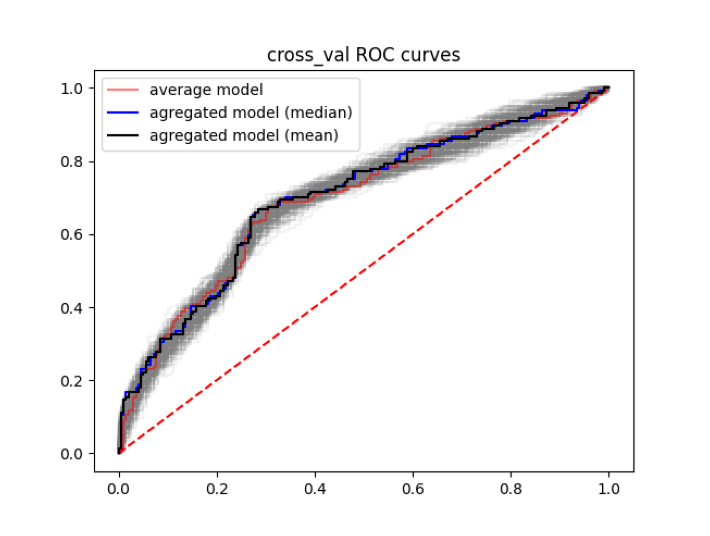

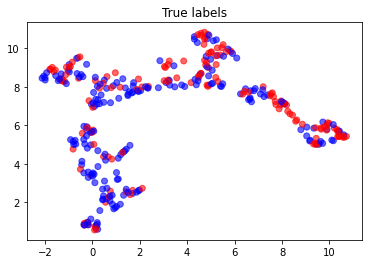

SVM labels


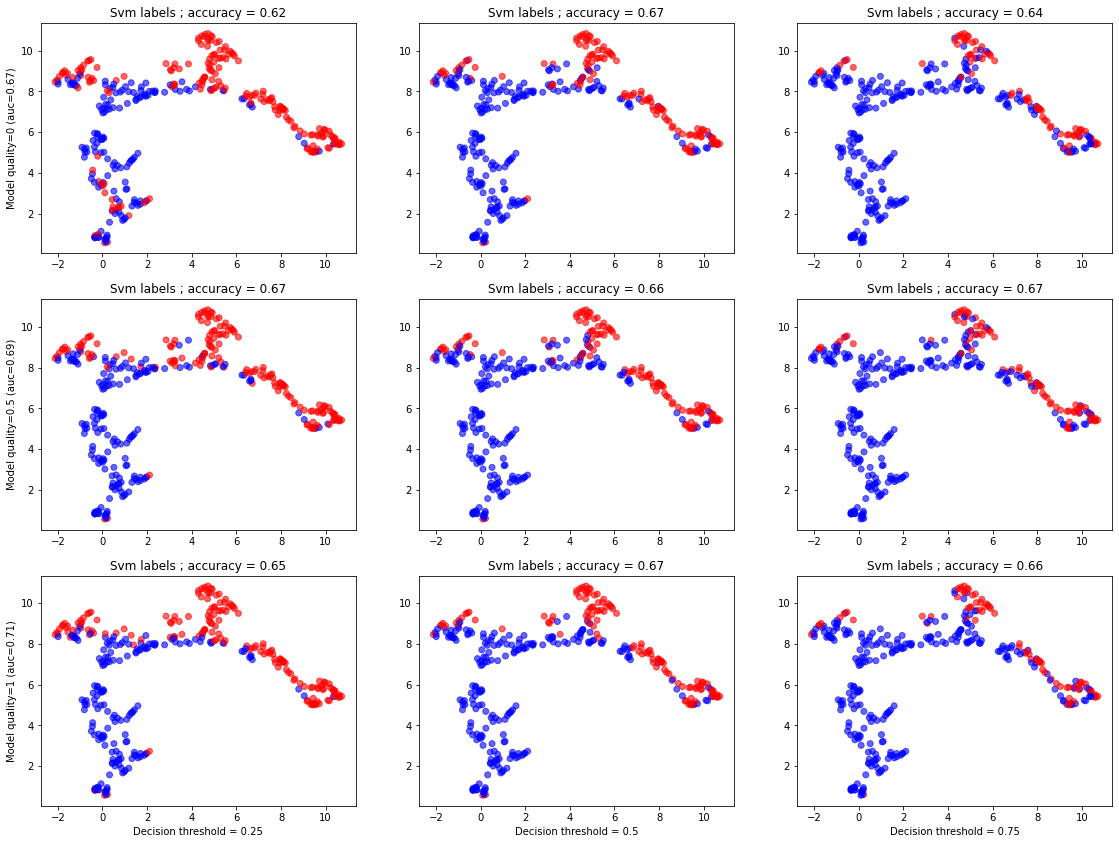

In [86]:
full_visualization(best_model)

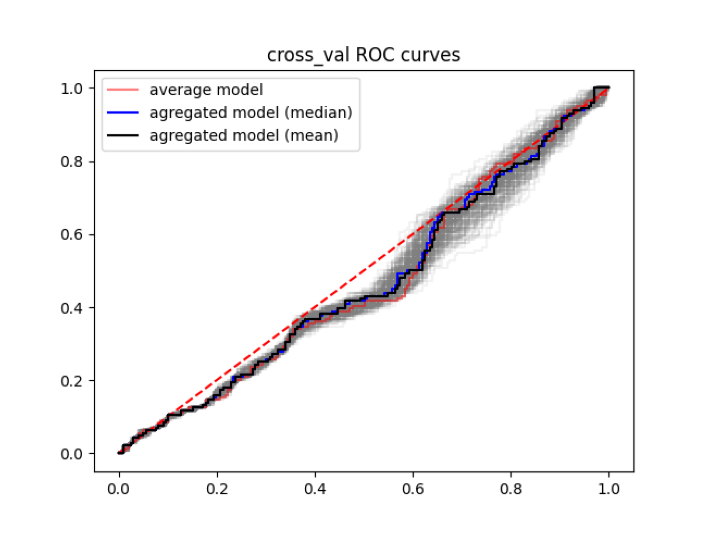

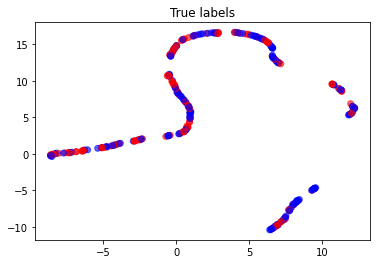

SVM labels


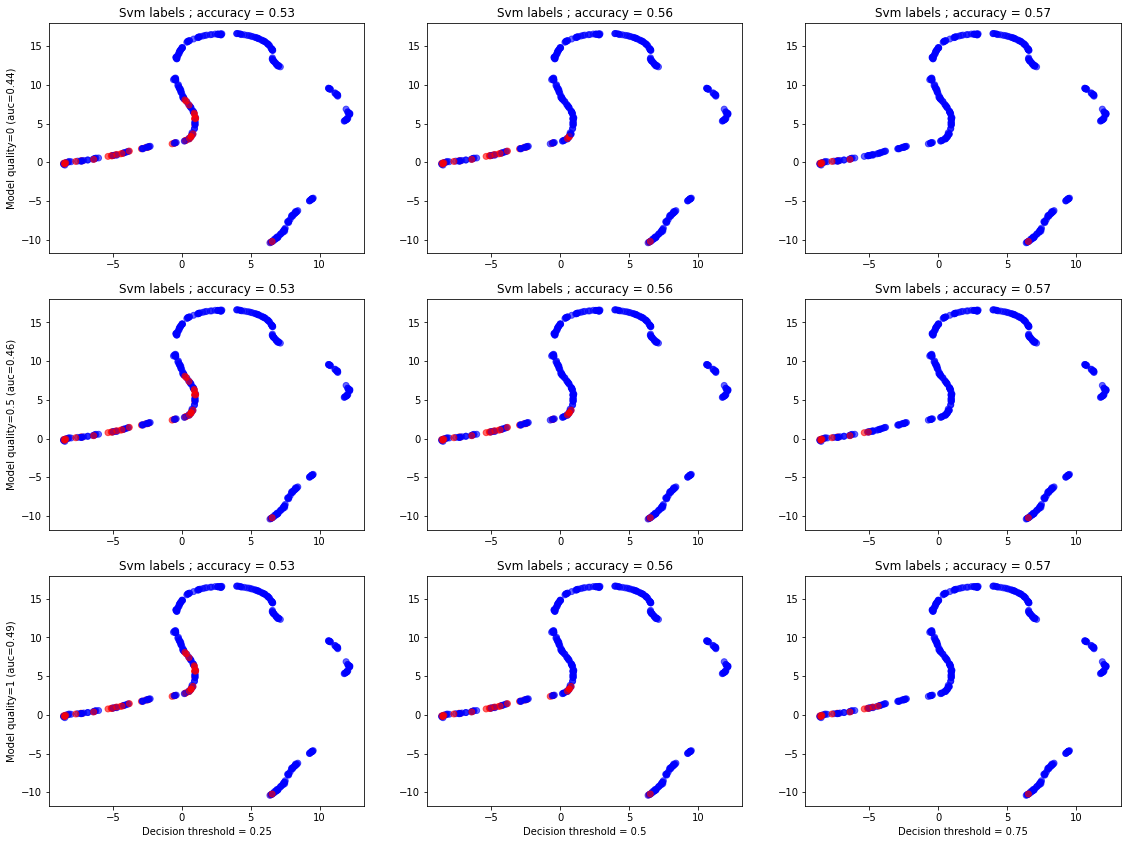

In [87]:
full_visualization(worst_model)

### Select other interesting models

High variance models

In [88]:
filtered_bdd = bdd[bdd.auc_std >= 0.05]
filtered_bdd

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
75,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.693590,0.051831,0.619449,0.052646,densenet,16,0.05,100,True,...,6,250,30,30,0.10,0.1,0.762840,1.369004,cingulate_HCP_half_1,Run_03_aymeric
76,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.670914,0.051652,0.596364,0.056285,densenet,16,0.05,100,True,...,6,250,30,30,0.10,0.1,1.159750,2.443445,cingulate_HCP_half_1,Run_03_aymeric
24,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.668507,0.053301,0.601525,0.057313,densenet,16,0.15,100,True,...,6,250,30,30,0.10,0.1,0.728199,1.858723,cingulate_HCP_half_1,Run_03_aymeric
78,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.668161,0.050466,0.598956,0.053273,densenet,16,0.05,100,True,...,6,250,30,30,0.10,0.1,1.041767,1.704926,cingulate_HCP_half_1,Run_03_aymeric
22,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.627084,0.052677,0.577161,0.053945,densenet,16,0.15,100,True,...,6,250,30,30,0.10,0.1,1.329955,3.381569,cingulate_HCP_half_1,Run_03_aymeric
47,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.626335,0.050238,0.598792,0.041902,convnet,16,0.15,100,False,...,10,250,30,30,0.01,0.1,0.172071,0.144276,cingulate_HCP_half_1,Run_03_aymeric
72,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.593398,0.056054,0.585232,0.040975,convnet,16,0.05,100,True,...,6,250,30,30,0.50,0.5,3.714237,3.622833,cingulate_HCP_half_1,Run_03_aymeric
5,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.581583,0.057815,0.562100,0.052206,convnet,16,0.15,100,True,...,6,250,4,4,0.10,0.1,4.480739,2.831487,cingulate_HCP_half_1,Run_03_aymeric
67,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.576889,0.056377,0.567038,0.039782,convnet,16,0.15,100,False,...,10,20,30,12,0.50,0.5,4.367877,3.828899,cingulate_HCP_half_1,Run_03_aymeric
43,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.574575,0.063551,0.555718,0.051553,convnet,16,0.15,100,True,...,6,250,4,4,0.10,0.1,4.664048,4.961831,cingulate_HCP_1mm,Run_03_aymeric


In [89]:
high_variance_good = filtered_bdd.iloc[0,:].model_path
high_variance_bad = filtered_bdd.iloc[-1,:].model_path

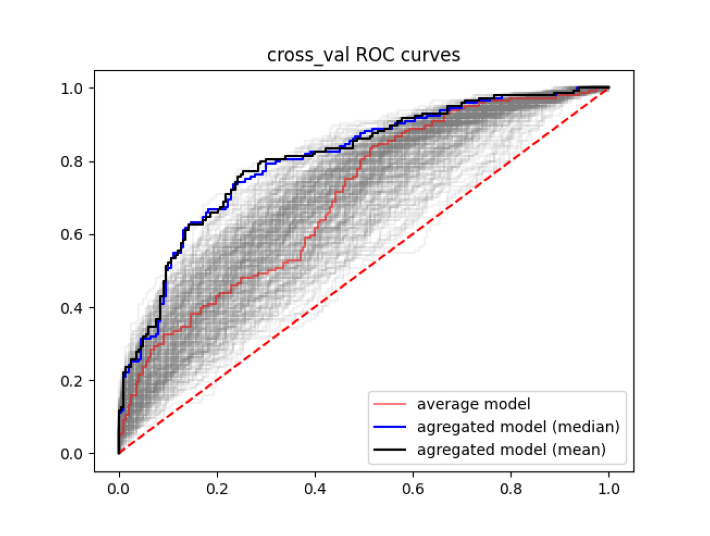

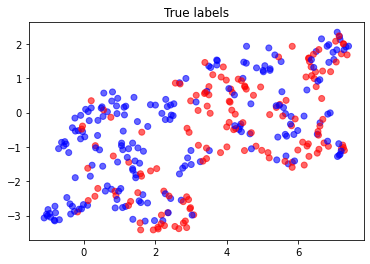

SVM labels


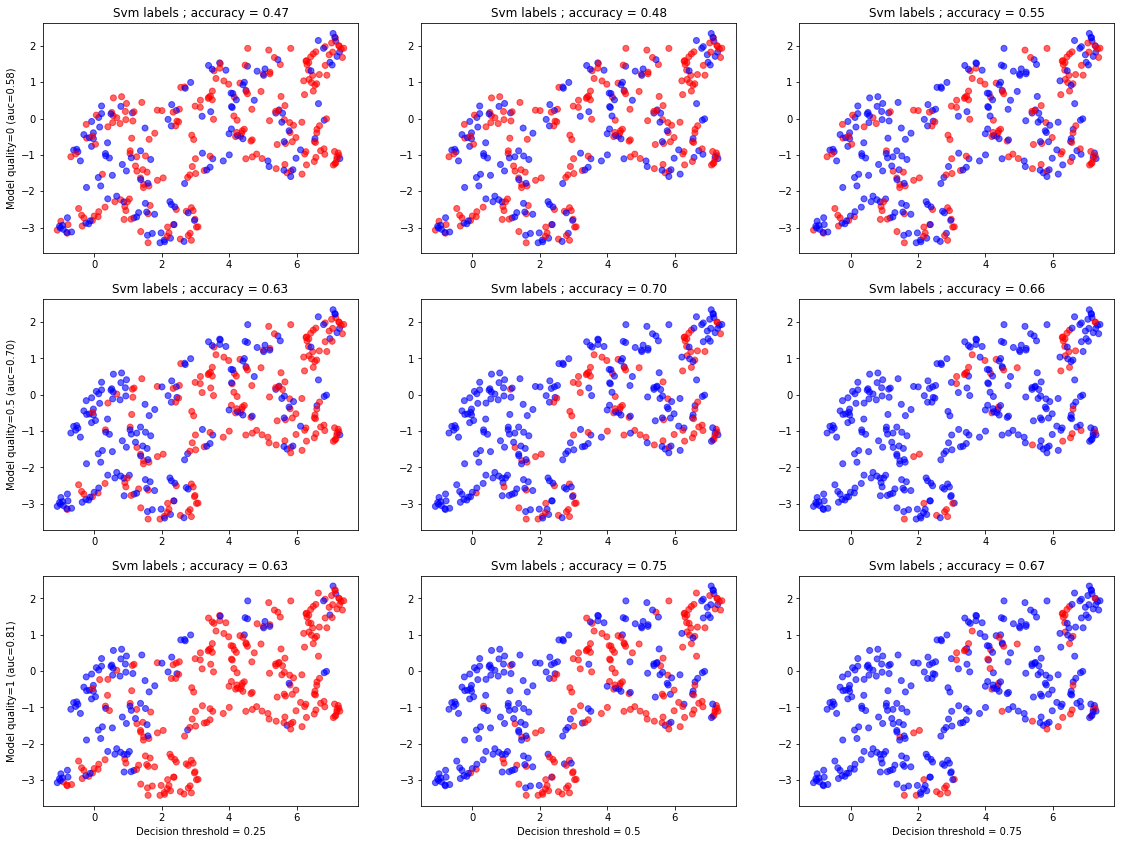

In [90]:
full_visualization(high_variance_good)

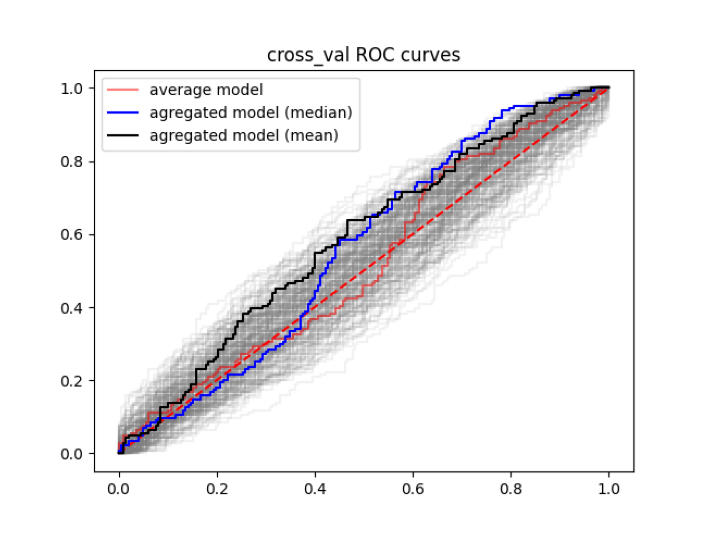

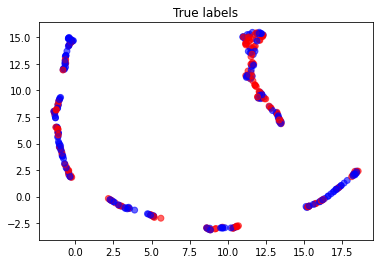

SVM labels


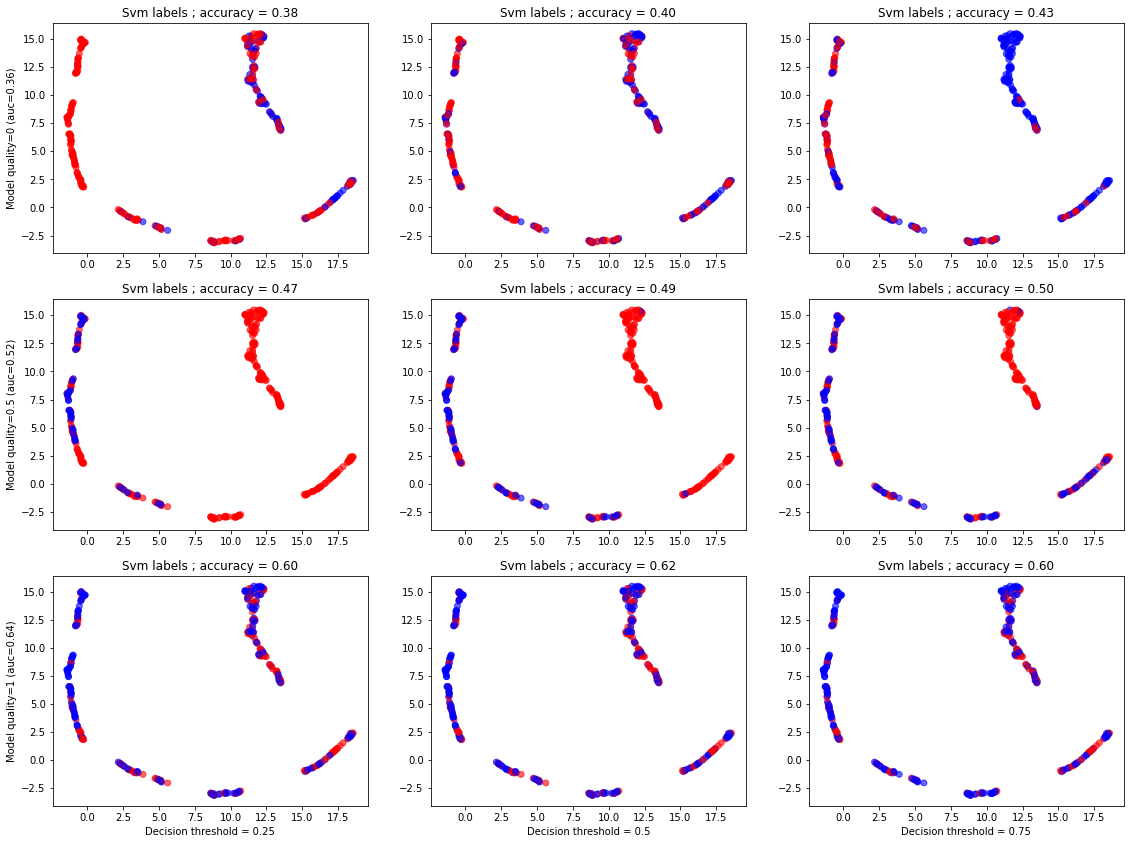

In [91]:
full_visualization(high_variance_bad)